convergence test of MC model

In [ ]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from math import sqrt, log, exp
from scipy import stats, linalg, interpolate
import scipy
import random
import math

In [318]:
def get_bs_price(s, sigma, t, r, k):
    y1 = (np.log(s/k) + (r + 0.5*(sigma**2))* t) / (sigma * np.sqrt(t))
    y2 = (np.log(s/k) + (r - 0.5*(sigma**2)) * t) / (sigma * np.sqrt(t))
    cdf1 = scipy.stats.norm.cdf(y1)
    cdf2 = scipy.stats.norm.cdf(y2)
    price = s * cdf1 - np.exp(-r * t) * k * cdf2
    return price

In [319]:
def call_MS(S0, sigma, T, r, K, iterations):
        
    option_price=np.zeros([iterations,2])
    rand=np.random.normal(0,1,[1,iterations])
    #find the stick price by using MC method
    stock_price=S0*np.exp(T*(r-0.5*sigma**2)+sigma*np.sqrt(T)*rand)
        
    #Find the intrisic value
    option_price[:,1]=stock_price-K
    
    #plt.plot(option_price[:150,1])
    #plt.title('MC model')
    #plt.ylabel('Option price')
    #plt.xlabel('Iterations')
    #plt.grid(True)
    #plt.show()
        
    average=np.sum(np.amax(option_price,axis=1))/float(iterations)
        #consider the time value
    price=np.exp(-1.0*r*T)*average
    return price

In [348]:
def FDM_Explicit_price(S_0, sigma, Tm, r, K, GridSize):
    TGrid = GridSize
    SGrid = GridSize
    Smax = 2 * S_0
    Tmax = Tm
    KGrid = np.linspace(0, Smax, SGrid)
    T = np.linspace(0, Tmax, TGrid)
    dt = T[1] - T[0]
    dS = KGrid[1] - KGrid[0]
    prices = np.zeros((SGrid, TGrid))
      
    prices[:,TGrid - 1] = np.maximum(KGrid - K, 0)
    prices[SGrid - 1,:] = (KGrid[SGrid - 1] - K) * np.exp((r) * T)
    prices[1,:] = 0
    
    a = 0.5 * dt * (sigma**2 * KGrid/(dS**2) - (r)/dS)* KGrid
    b = 1 - dt * (sigma**2 * KGrid**2/(dS**2) + (r))
    c = 0.5 * dt * (sigma**2 * KGrid/(dS**2) + (r)/dS)* KGrid

    for j in range(TGrid - 2, 0, -1) :
        for i in range(1, SGrid - 2) :
            prices[i,j] = a[i]*prices[i-1, j+1] + b[i]*prices[i, j+1] + c[i]*prices[i+1, j+1]

    expFDMPrice = interpolate.interp1d(KGrid, prices[:,1])(S_0)
    return expFDMPrice

In [349]:
def FDM_Implicit_price(S_0, sigma, Tm, r, K, GridSize):
    TGrid = GridSize
    SGrid = GridSize
    Smax = 2 * S_0
    Tmax = Tm
    KGrid = np.linspace(0, Smax, SGrid)
    T = np.linspace(0, Tmax, TGrid)
    dt = T[1] - T[0]
    dS = KGrid[1] - KGrid[0]
    prices = np.zeros((SGrid, TGrid))
      
    prices[:,TGrid - 1] = np.maximum(KGrid - K, 0)
    prices[SGrid - 1,:] = (KGrid[SGrid - 1] - K) * np.exp((r) * T)
    prices[1,:] = 0
    
    a = 0.5 * dt*((r)/dS - sigma**2 * KGrid/(dS**2)) * KGrid
    b = 1 + dt * (sigma**2 * KGrid**2/(dS**2) + (r))
    c = - 0.5 * dt*((r)/dS + sigma**2 * KGrid/(dS**2)) * KGrid

    coeff = np.diag(a[2:SGrid],-1) + np.diag(b[1:SGrid]) + np.diag(c[1:SGrid-1],1)
    P, L, U = scipy.linalg.lu(coeff)
    Boundary = np.zeros((SGrid - 1,1))

    for j in range(TGrid - 2, 0, -1) :
        Boundary[0] = - a[2] * prices[1,j]
        prices[1:SGrid, j:j+1] = (linalg.inv(U).dot(linalg.inv(L).dot(prices[1:SGrid, (j + 1):(j + 2)] + Boundary)))

    impFDMPrice = interpolate.interp1d(KGrid, prices[:,1])(S_0)
    return impFDMPrice

In [495]:
def FDM_CN_price(S_0, sigma, Tm, r, K, GridSize):
    TGrid = GridSize
    SGrid = GridSize
    Smax = 2 * S_0
    Tmax = Tm
    KGrid = np.linspace(0, Smax, SGrid)
    T = np.linspace(0, Tmax, TGrid)
    dt = T[1] - T[0]
    dS = KGrid[1] - KGrid[0]
    prices = np.zeros((SGrid, TGrid))
     
    prices[:,TGrid - 1] = np.maximum(KGrid - K, 0)
    prices[SGrid - 1,:] = (KGrid[SGrid - 1] - K) * np.exp((r) * T)
    prices[1,:] = 0
    
    a = 0.25*dt*( -(r)/dS + (sigma**2) * KGrid/dS**2)*KGrid
    b = -0.5*dt*((sigma**2) * (KGrid**2)/(dS**2) + (r))
    c = 0.25*dt*((r)/dS + (sigma**2) * KGrid/dS**2)*KGrid

    coeff = -np.diag(a[2:SGrid],-1) + np.diag(1 - b[1:SGrid]) - np.diag(c[1:SGrid-1],1)
    P, L, U = scipy.linalg.lu(coeff)
    D = np.diag(a[2:SGrid],-1) + np.diag(1 + b[1:SGrid]) + np.diag(c[1:SGrid-1],1)
    Boundary = np.zeros((SGrid - 1,1))

    for j in range(TGrid - 2, 0, -1) :
        Boundary[0] = a[1] * (prices[0,j] + prices[0,j+1]);
        Boundary[SGrid - 2] = c[SGrid - 1] * (prices[SGrid - 1,j] + prices[SGrid - 1,j+1]);
        prices[1:SGrid, j:j+1]= linalg.inv(U).dot(linalg.inv(L).dot(D.dot(prices[1:SGrid, (j + 1):(j + 2)] + Boundary)));
    
    CNFDMPrice = interpolate.interp1d(KGrid, prices[:,1])(S_0)

    return CNFDMPrice

set the range of iterations

In [350]:
T = 1
S_0 = 100
r = 0.1
sigma = 0.2
K = 100
iterations = np.linspace(1, 10000, num=1000)

In [351]:
price = get_bs_price(S_0, sigma, T, r, K)
print(price)

13.2696765847


In [352]:
prices = np.zeros(len(iterations))
for i in range(len(iterations)):
    prices[i]=price
mcprices = np.zeros(len(iterations))
print(mcprices[3])

0.0


In [353]:
for i in range(len(iterations)):
    mcprices[i] = 10*math.log10( (abs(call_MS(S_0, sigma, T, r, K, int(iterations[i]) ) - prices[i]))/prices[i])

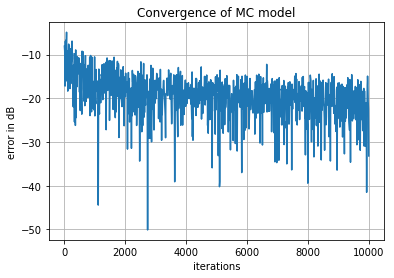

In [354]:
plt.plot(iterations,mcprices)
plt.title('Convergence of MC model')
plt.ylabel('error in dB')
plt.xlabel('iterations')
plt.grid(True)
plt.show()

In [355]:
iteration=2000
meow=np.zeros(1000)

In [380]:
%%time
for n in range(1000):
    meow[n]=call_MS(S_0, sigma, T, r, K, iteration) 

CPU times: user 46.1 ms, sys: 4.09 ms, total: 50.2 ms
Wall time: 49.7 ms


cannot set too much meow, otherwise it's cheating for MC method, each meow increase the iterations!!!!!!

In [357]:
print(100* (abs( price-(meow[1]+meow[2]+meow[3]+meow[4]+meow[5]+meow[6]+meow[7]+meow[8]+meow[9]+meow[10])/10 ))/price)

0.273291363756


In [569]:
n=500000
iteration=int(math.sqrt(n))
print(iteration)

707


In [570]:
%%time
for n in range(10):
    mua=FDM_CN_price(S_0, sigma, T, r, K, iteration) 

CPU times: user 12min 58s, sys: 35.8 s, total: 13min 34s
Wall time: 5min 40s


In [568]:
print(100* (abs( price-(mua)))/price)

3.76459566253e+89


14 April 2018